In [1]:
import pandas as pd
import numpy as np
from numpy import sqrt
import os
import requests
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Get the current working directory
cwd = os.getcwd()
print(f"Current Working Directory: {cwd}")

# Define the relative path to states.csv
data_path = os.path.join(cwd, '..', 'data')

# Normalize path to avoid issues
data_path = os.path.abspath(data_path)
print(f"Resolved Data Path: {data_path}")

Current Working Directory: C:\Users\josue\Documents\Python\projects\Analyzing_US_Census_Data_in_Python\notebooks
Resolved Data Path: C:\Users\josue\Documents\Python\projects\Analyzing_US_Census_Data_in_Python\data


## Measuring Segregation
Explore racial segregation in America. Calculate the Index of Dissimilarity, and important measure of segregation. Learn about and use Metropolitan Statistical Areas, and important geography for urban research. Study segregation changes over time in Chicago.

### Getting the database `tracts`

In [25]:
# Build base URL
HOST = "https://api.census.gov/data"
year = "2012"
dataset = "acs/acs5"
base_url = "/".join([HOST, year, dataset])

# Specify requested variables
# B01001_001E = Total population (estimate)
# B03002_003E = Nonhispanic White population (estimate)
# B03002_004E = Nonhispanic Black population (estimate)

# Specify requested variables
get_vars = ["NAME", "B01001_001E", "B03002_003E", "B03002_004E"]
# Create dictionary of predicates
predicates = {}
predicates["get"] = ",".join(get_vars)
# Requested geography
# The geography requires for each of the MSA's to request the data for the state and county.
predicates["for"] = "county:*"
r = requests.get(base_url, params=predicates)

In [26]:
# Create user-friendly column names
col_names = ["name", "pop", "white", "black", "state","county"]
# Load JSON response into DataFrame
tracts = pd.DataFrame(columns=col_names, data=r.json()[1:])
# Cast count columns to int data type
tracts[["pop", "white", "black"]] = tracts[["pop", "white", "black"]].astype(int)

In [30]:
tracts.sample(5)

,name,pop,white,black,state,county
2475,"Ashe County, North Carolina",27099,25260,109,37,009
1742,"Watonwan County, Minnesota",11177,8571,12,27,165
903,"Hillsborough County, Florida",1238365,665123,194233,12,057
2930,"Taylor County, Wisconsin",20631,20034,65,55,119
2104,"Franklin County, Tennessee",40972,36766,1964,47,051


### Measuring Segregation: The Index of Dissimilarity


#### Calculating D for One State
Compute the Index of Dissimilarity for the state of Georgia. The formula for the Index of Dissimilarity is:

$$D = \frac{1}{2}\sum{\left\lvert \frac{a}{A} - \frac{b}{B} \right\rvert}$$

In this case, Group A will be Whites, Group B will be Blacks. $ a $ and $ b $ represent the White and Black population of the small geography (tracts), while $ A $ and $ B $ represent the White and Black population of the larger, containing geography (e.g. Georgia, postal code = GA, FIPS code = 13).

In [31]:
# Define convenience variables to hold column names
w = "white"
b = "black"

# Extract Georgia tracts
ga_tracts = tracts[tracts['state']=='13']

# Print sums of Black and White residents of Georgia
print(ga_tracts[[w,b]].sum())

# Calculate Index of Dissimilarity and print rounded result
w_total = ga_tracts[w].sum()
b_total = ga_tracts[b].sum()
D = 0.5 * sum(abs(ga_tracts[w] / w_total - ga_tracts[b] / b_total))

print("Dissimilarity (Georgia):", round(D, 3))  

white    5424856
black    2932160
dtype: int64
Dissimilarity (Georgia): 0.354


#### Calculating D in a Loop
Is Georgia's Index of Dissimilarity high or low? Let's compare it to Illinois (FIPS = 17), home of Chicago.

In this exercise we will use a loop to calculate $ D$ for all states, then compare Georgia and Illinois.

In [32]:
# Get list of state FIPS Codes
states = list(tracts["state"].unique())

state_D = {}  # Initialize dictionary as collector
for state in states:
    # Filter by state
    tmp = tracts[tracts['state']==state]
    
    # Add Index of Dissimilarity to Dictionary
    w_tot = tmp[w].sum()
    b_tot =tmp[b].sum()
    state_D[state] = 0.5 * sum(abs(tmp[w]/w_tot-tmp[b]/b_tot))

# Print D for Georgia (FIPS = 13) and Illinois (FIPS = 17)    
print("Georgia D =", round(state_D["13"], 3))
print("Illinois D =", round(state_D["17"], 3))

Georgia D = 0.354
Illinois D = 0.438


#### Calculating D Using Grouping in Pandas
Performing a calculation over subsets of a DataFrame is so common that `pandas` gives us an alternative to doing it in a loop, the `groupby` method. In the sample code, `groupby` is used first to group tracts by state, i.e. those rows having the same value in the `"state"` column. The `sum()` method is applied by group to the columns.

In [8]:
# Sum Black and White residents grouped by state
sums_by_state = tracts.groupby("state")[[w, b]].sum()

# Drop columns if they already exist to prevent duplicates
columns_to_add=['white_sum','black_sum']
tracts=tracts.drop(columns=[col for col in columns_to_add if col in tracts], errors='ignore')
 
# Merge the sum with the original tract populations
tracts = pd.merge(tracts, sums_by_state, left_on = "state", 
    right_index = True, suffixes = ("", "_sum"))

display(tracts.head(2))

# Calculate inner expression of Index of Dissimilarity formula
tracts["D"] = abs(tracts[w] / tracts[w + "_sum"] - tracts[b] / tracts[b + "_sum"])

# Calculate the Index of Dissimilarity
display(0.5 * tracts.groupby('state')["D"].sum())

,name,pop,white,black,state,county,white_sum,black_sum
0,"Ellis County, Oklahoma",4102,3565,0,40,045,2589210,278887
1,"Grady County, Oklahoma",54351,44567,1166,40,051,2589210,278887


state
01    0.364086
02    0.345992
04    0.147829
05    0.552564
06    0.329605
08    0.464624
09    0.211353
10    0.141408
11    0.000000
12    0.332714
13    0.358637
15    0.313390
16    0.299911
17    0.423544
18    0.504898
19    0.389994
20    0.381651
21    0.457009
22    0.278304
23    0.320789
24    0.466243
25    0.310150
26    0.421004
27    0.397329
28    0.343951
29    0.538619
30    0.282624
31    0.444908
32    0.300548
33    0.262588
34    0.371777
35    0.232328
36    0.426251
37    0.334345
38    0.322805
39    0.450636
40    0.382497
41    0.419166
42    0.508741
44    0.368670
45    0.275191
46    0.401176
47    0.537896
48    0.332044
49    0.252271
50    0.296343
51    0.366846
53    0.348270
54    0.354082
55    0.622830
56    0.340376
72    0.428930
Name: D, dtype: float64

### Metropolitan Segregation ***(Not available data out of US in DataCamp or Census.gov)***

#### Geting the database `msa`

In [9]:
# Build base URL
HOST = "https://api.census.gov/data"
year = "2017"
dataset = "acs/acs5"
base_url = "/".join([HOST, year, dataset])

# Specify requested variables
# B01001_001E = Total population (estimate)
# B03002_003E = Nonhispanic White population (estimate)
# B03002_004E = Nonhispanic Black population (estimate)

# Specify requested variables
get_vars = ["NAME", "B01001_001E", "B03002_003E", "B03002_004E"]
# Create dictionary of predicates
predicates = {}
predicates["get"] = ",".join(get_vars)
# Requested geography
# The geography requires for each of the MSA's to request the data for the state and county.
predicates["for"] = "metropolitan statistical area/micropolitan statistical area:*"
r = requests.get(base_url, params=predicates)

In [10]:
# Create user-friendly column names
col_names = ["name", "pop", "white", "black", "msa"]
# Load JSON response into DataFrame
msa = pd.DataFrame(columns=col_names, data=r.json()[1:])
# Cast count columns to int data type
msa[["pop", "white", "black"]] = msa[["pop", "white", "black"]].astype(int)

In [33]:
msa.head()

,name,pop,white,black,msa,D
24,"Tampa-St. Petersburg-Clearwater, FL Metro Area",2978209,1911274,338273,45300,0.264460
67,"Virginia Beach-Norfolk-Newport News, VA-NC Met...",1717708,958106,515483,47260,0.299217
82,"Washington-Arlington-Alexandria, DC-VA-MD-WV M...",6090196,2818715,1514907,47900,0.472618
191,"Kansas City, MO-KS Metro Area",2088830,1525181,256523,28140,0.446209
251,"Las Vegas-Henderson-Paradise, NV Metro Area",2112436,931891,228127,29820,0.000000


#### Creation of msa_def

The `msa_def` variable was created using two primary data sources:

1. **Census.gov Data**: The MSA names (for metropolitan areas) were retrieved from the Census Bureau's API. This data provided the names associated with each Metropolitan Statistical Area (MSA).

2. **NBER Crosswalk**: Due to limited access to the full CBSA delineation file from the Census, the definition of counties and states within the Metropolitan Areas was downloaded from the **National Bureau of Economic Research (NBER)**. This file provided the necessary crosswalk to map counties and states to their respective MSAs.


The `msa_def` variable was created by merging a crosswalk file (containing MSA codes, county names, and state names) with MSA names retrieved from the Census API. The numeric columns were formatted, and columns were reordered and renamed to ensure clarity and consistency for further analysis.


In [11]:
# Fetching MSA Data from the Census API

# Define the API endpoint and dataset parameters
HOST = "https://api.census.gov/data"
year = "2012"  # The year for which the data is requested (can be adjusted as necessary)
dataset = "acs/acs5"  # American Community Survey dataset
base_url = "/".join([HOST, year, dataset])  # Complete base URL

# Specify the variables to be retrieved from the API
get_vars = ["NAME"]  # Requesting the name of the MSA

# Include API key for authentication (already set in the environment)
# api_key = 'YOUR_API_KEY'  # Your API Key here

# Define the API request parameters (predicates)
predicates = {
    "get": ",".join(get_vars),  # Specify the variables to retrieve
    "for": "metropolitan statistical area/micropolitan statistical area:*",  # Request for all MSAs
    #"key": api_key  # API key for access
}

# Send GET request to the Census API to fetch MSA data
r = requests.get(base_url, params=predicates)

# Create user-friendly column names for the DataFrame
col_names = ["name", "msa"]

# Load the JSON response from the API into a pandas DataFrame, excluding the header row
msa_names = pd.DataFrame(columns=col_names, data=r.json()[1:])


In [12]:
# Define the file path for the CSV file
csv_file = data_path + '\\cbsa2fipsxw.csv'

# Read the CSV file into a DataFrame
msa_cs = pd.read_csv(csv_file)

# Select relevant columns from the CSV data for further analysis
msa_cs = msa_cs[['cbsacode', 'countycountyequivalent', 'statename', 'fipscountycode', 'fipsstatecode']]

# Rename columns to more meaningful names for better readability
msa_cs.columns = ['msa', 'county_name', 'state_name', 'county', 'state']

# Convert numeric columns to strings with leading zeros to match required lengths
msa_cs['msa'] = msa_cs['msa'].astype('str').str.zfill(5)   # MSA code as a 5-digit string
msa_cs['county'] = msa_cs['county'].astype('str').str.zfill(3)  # County code as a 3-digit string
msa_cs['state'] = msa_cs['state'].astype('str').str.zfill(2)  # State code as a 2-digit string

In [13]:
# Merge the county-state DataFrame with the names 
# Use a left join to retain all data from msa_cs and match on 'msa'
msa_def = msa_cs.merge(msa_names, on='msa', how='left')

# Reorganize and rename columns for final output
# Select and reorder columns to have them in a desired format
msa_def = msa_def[['msa', 'name', 'county_name', 'state_name', 'state', 'county']]

# Rename columns for clarity in final DataFrame
msa_def.columns = ['msa', 'msa_name', 'county_name', 'state_name', 'state', 'county']

#### Function to Calculate `D`
Calculating the *Index of Dissimilarity* requires multiple steps and has high reuse potential.Create a function of dissimilarity. The function's input parameters will be a DataFrame of small area geographies (such as tracts) and three column names: the two columns with population counts of Group A and Group B, and the column with the names or geographic identifiers of the container geography (such as states or metro areas.

In [14]:
def dissimilarity(df, col_A, col_B, group_by):
    # Compute the total for each group without merging
    df[col_A + "_sum"] = df.groupby(group_by)[col_A].transform('sum')
    df[col_B + "_sum"] = df.groupby(group_by)[col_B].transform('sum')
    
    # Calculate the dissimilarity measure for each row
    df["D"] = abs(df[col_A] / df[col_A + "_sum"] - df[col_B] / df[col_B + "_sum"])
    
    # Aggregate the dissimilarity index at the group level
    return 0.5 * df.groupby(group_by)["D"].sum().to_frame()

#### Joining Tracts and Metropolitan Areas
In order to focus on how the merge method works, Dissimilarity Function is used. 

To apply this function, you need to add the MSA identifiers to the tracts DataFrame. Use state and county, present in both DataFrames, as the join keys. At the end, use seaborn's stripplot method to show the ten most segregated metros.

`msa_def` It is the data with the counties that make up each MSA.

In [15]:
# Find identifiers for 50 largest metros by population
msa50 = list(msa.nlargest(50,'pop')["msa"])

# Join MSA identifiers to tracts, restrict to largest 50 metros
msa_tracts = pd.merge(tracts, msa_def, on = ['state','county'])
msa_tracts = msa_tracts[msa_tracts["msa"].isin(msa50)]

# Calculate D using custom function, merge back into MSA
msa_D = dissimilarity(msa_tracts, "white", "black", "msa")
msa = pd.merge(msa, msa_D, left_on='msa', right_index=True)

In [16]:
tracts.shape

(3220, 9)

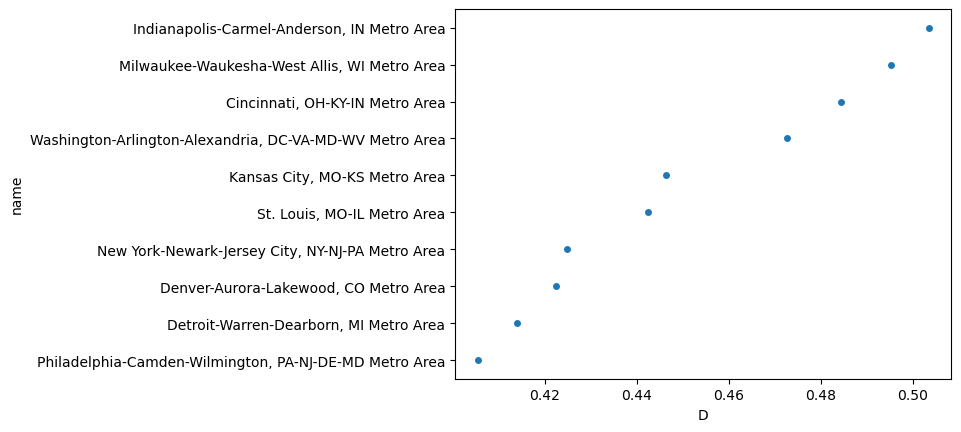

In [17]:
# Plot ten most segregated metros
sns.stripplot(x = "D", y = "name", data = msa.nlargest(10, "D"))
plt.show()

In [18]:
msa.sort_values('D')

,name,pop,white,black,msa,D
251,"Las Vegas-Henderson-Paradise, NV Metro Area",2112436,931891,228127,29820,0.000000
884,"San Diego-Carlsbad, CA Metro Area",3283665,1517153,154599,41740,0.000000
742,"Phoenix-Mesa-Scottsdale, AZ Metro Area",4561038,2573055,228477,38060,0.015039
890,"San Jose-Sunnyvale-Santa Clara, CA Metro Area",1969897,643138,45916,41940,0.022936
881,"Salt Lake City, UT Metro Area",1170057,850377,18653,41620,0.045545
835,"Raleigh, NC Metro Area",1273985,788837,249000,39580,0.049484
848,"Riverside-San Bernardino-Ontario, CA Metro Area",4476222,1493828,309795,40140,0.122027
905,"Seattle-Tacoma-Bellevue, WA Metro Area",3735216,2424748,202368,42660,0.125790
336,"Austin-Round Rock, TX Metro Area",2000590,1057470,138478,12420,0.126428
531,"Miami-Fort Lauderdale-West Palm Beach, FL Metr...",6019790,1891492,1217737,33100,0.210677


#### Characteristics of Segregated Metros ***(Data not available out of US)***
That segregation is higher in Northern industrialized metro areas. But these are also large, diverse metro areas. Are low diversity cities just getting a pass? Let's compare how size and diversity correlate with metropolitan segregation.

The msa DataFrame, as modified previously with the addition of the Index of Dissimilarity, has been loaded. The columns are listed in the console. Total population appears in the population column.

pandas and seaborn have been loaded using the usual aliases.